See https://www.espn.com/nba/game/_/gameId/401360435

In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
team = 'DEN'

In [3]:
active_players = dict()
active_players['DEN'] = ['Monte Morris', 'Will Barton', 'Jeff Green', 'Aaron Gordon', 'Nikola Jokic']
players = active_players[team]

In [4]:
window = 3
T = int(4 * 12 / window)
epsilon = 0.05
H_symbols = [0, 1, 2]

In [5]:
def cond(player, h1, h2, t, M_, N_, R_): # P(H_t^player = h1 | H_{t-1}^player = h2, O_{t-1})    
    # Requires M_, N_, R_, Os
    v = [N_[h2][h1]]
    for teammate in players:
        v.append(M_[Os[teammate][t-1]][h1])
            
    v = np.array(v)
    return np.dot(R_[player], v) 

In [6]:
def calcPlayerStats(team, df):
    score_diff = []
    players = active_players[team]
    player_stats = {p : [] for p in players}
    start = 0
    period = 1

    while period <= 4:
        end_str = str(start + window).zfill(2)
        start_str = str(start).zfill(2)

        df_window = df[(df['period'] == period) & (df['elapsed'] >= f'0:{start_str}:00') & (df['elapsed'] <= f'0:{end_str}:00')]
        
        df_team = df_window[df_window['team'] == team]
        df_enemy = df_window[df_window['team'] != team]
        
        team_PTS = df_team['points'].sum(skipna=True)
        enemy_PTS = df_enemy['points'].sum(skipna=True)
        
        score_diff.append(team_PTS - enemy_PTS)
        # Calculate PIE for each player
        #  PIE = (PTS + FGM + FTM – FGA – FTA + Deff.REB + Off.REB/2 + AST + STL + BLK/2 – PF – TO) / 
        #        (GAME_PTS + GAME_FGM + ... - GAME_PF - GAME_TO)
        # Calculate Game stats
        G_PTS = df_window['points'].sum(skipna=True)
        G_FGM = len(df_window[(df_window['event_type'] == 'shot') & (df_window['result'] == 'made')])
        G_FGA = len(df_window[(df_window['event_type'] == 'shot')])
        G_FTM = len(df_window[(df_window['event_type'] == 'free throw') & (df_window['result'] == 'made')])
        G_FTA = len(df_window[(df_window['event_type'] == 'free throw')])
        G_AST = len(df_window[df_window['assist'].notnull()])

        G_DEF_REB = len(df_window[df_window['type'] == 'rebound defensive'])
        G_OFF_REB = len(df_window[df_window['type'] == 'rebound offensive'])

        G_STL = len(df_window[df_window['steal'].notnull()])
        G_BLK = len(df_window[df_window['block'].notnull()])
        G_PF = len(df_window[df_window['event_type'] == 'foul'])
        G_TO = len(df_window[df_window['event_type'] == 'turnover'])

        game_sum = G_PTS + G_FGM + G_FTM - G_FGA - G_FTA + G_DEF_REB + G_OFF_REB / 2 + G_AST + G_STL + G_BLK/2 - G_PF - G_TO
            
        for p in players:
            df_player = df_window[(df_window['a1'] == p) | (df_window['a2'] == p) | (df_window['a3'] == p) 
                                  | (df_window['a4'] == p) | (df_window['a5'] == p) | (df_window['h1'] == p)
                                  | (df_window['h2'] == p) | (df_window['h3'] == p) | (df_window['h4'] == p)
                                  | (df_window['h5'] == p)]
            
            # Calculate PIE for each player
            PTS = df_player[(df_player['event_type'] == 'shot') & (df_player['player'] == p)]['points'].sum(skipna=True)

            FGM = len(df_player[(df_player['event_type'] == 'shot') 
                                & (df_player['result'] == 'made') 
                                & df_player['player'] == p])
            FGA = len(df_player[(df_player['event_type'] == 'shot') & df_player['player'] == p])
            FTM = len(df_player[(df_player['event_type'] == 'free throw') 
                                & (df_player['result'] == 'made')
                                & (df_player['player'] == p)])
            FTA = len(df_player[(df_player['event_type'] == 'free throw') & df_player['player'] == p])
            AST = len(df_player[df_player['assist'] == p])

            DEF_REB = len(df_player[(df_player['player'] == p) & (df_player['type'] == 'rebound defensive')])
            OFF_REB = len(df_player[(df_player['type'] == 'rebound offensive') & (df_player['player'] == p)])

            STL = len(df_player[df_player['steal'] == p])
            BLK = len(df_player[df_player['block'] == p])
            PF = len(df_player[(df_player['player'] == p) & (df_player['event_type'] == 'foul')])
            TO = len(df_player[(df_player['player'] == p) & (df_player['event_type'] == 'turnover')])
            
            player_sum = PTS + FGM + FTM - FGA - FTA + DEF_REB + OFF_REB / 2 + AST + STL + BLK/2 - PF - TO
            
            # total time in seconds that player p played during the window
            df_play_length = df_player['play_length']
            time = df_play_length.agg(lambda col : sum(int(t[-2:]) for t in col)) if len(df_play_length) else 0
            
            
            if game_sum == 0:
                PIE = np.nan
            else:
                PIE = player_sum / game_sum
                
            # Add stats to dict
            player_stats[p].append((PIE, player_sum, game_sum, time))
        
        # update window
        start += window
        if start >= 12:
            start = 0 
            period += 1
        
    return player_stats, score_diff

In [7]:
df = pd.read_csv('../team-data/2021-2022_NBA_PbP_Logs/[2022-01-11]-0022100616-DEN@LAC.csv')
player_stats, score_diff = calcPlayerStats(team, df)
player_stats

{'Monte Morris': [(0.0, 0.0, 12.0, 170),
  (0.6, 3.0, 5.0, 189),
  (0.15384615384615385, 1.0, 6.5, 133),
  (0.0, 0.0, 9.0, 0),
  (0.0, 0.0, 10.0, 0),
  (0.0, 0.0, 3.0, 37),
  (0.5, 3.0, 6.0, 195),
  (0.5, 2.0, 4.0, 186),
  (0.3, 3.0, 10.0, 179),
  (0.2962962962962963, 4.0, 13.5, 174),
  (-0.08333333333333333, -1.0, 12.0, 168),
  (0.0, 0.0, 6.0, 75),
  (0.0, 0.0, 11.5, 4),
  (0.0, 0.0, 19.5, 178),
  (0.09523809523809523, 1.0, 10.5, 182),
  (0.0, 0.0, 11.0, 184)],
 'Will Barton': [(0.0, 0.0, 12.0, 0),
  (0.0, 0.0, 5.0, 0),
  (0.0, 0.0, 6.5, 0),
  (0.0, 0.0, 9.0, 0),
  (0.0, 0.0, 10.0, 0),
  (0.0, 0.0, 3.0, 0),
  (0.0, 0.0, 6.0, 0),
  (0.0, 0.0, 4.0, 0),
  (0.0, 0.0, 10.0, 0),
  (0.0, 0.0, 13.5, 0),
  (0.0, 0.0, 12.0, 0),
  (0.0, 0.0, 6.0, 0),
  (0.0, 0.0, 11.5, 0),
  (0.0, 0.0, 19.5, 0),
  (0.0, 0.0, 10.5, 0),
  (0.0, 0.0, 11.0, 0)],
 'Jeff Green': [(0.0, 0.0, 12.0, 0),
  (0.0, 0.0, 5.0, 0),
  (0.46153846153846156, 3.0, 6.5, 166),
  (0.2222222222222222, 2.0, 9.0, 182),
  (0.3, 3.0, 10.0,

In [8]:
with open(f'../team-data/average/{team}_average.pkl', 'rb') as file:
        avg_stats = pickle.load(file)
avg_stats

{'Monte Morris': 0.08914934171769368,
 'Will Barton': 0.10519931372434985,
 'Jeff Green': 0.06201797816559909,
 'Aaron Gordon': 0.09976851265882133,
 'Nikola Jokic': 0.2171786514834848}

In [9]:
Os = {p: [] for p in players}
for p in players:
    for val in player_stats[p]:
        time_played = val[3]
        if time_played > 0:
            pie = val[0]
            label = 0 if pie < avg_stats[p] - epsilon else 2 if pie > avg_stats[p] + epsilon else 1
            Os[p].append(label)
        else:
            try:
                Os[p].append(Os[p][-1])
            except:
                Os[p].append(1)
Os

{'Monte Morris': [0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 0, 0, 0, 0, 1, 0],
 'Will Barton': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 'Jeff Green': [1, 1, 2, 2, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0],
 'Aaron Gordon': [0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 2, 2, 2, 1],
 'Nikola Jokic': [2, 1, 2, 0, 0, 0, 0, 2, 1, 2, 0, 0, 0, 0, 2, 2]}

In [10]:
with open(f'./profiles2/{team}_profile.pkl', 'rb') as file:
    params = pickle.load(file)
params

{'M': array([[0. , 0.3, 0.7],
        [0.2, 0.6, 0.2],
        [0.7, 0.3, 0. ]]),
 'N': array([[0.7, 0.2, 0.1],
        [0.1, 0.7, 0.2],
        [0. , 0.2, 0.8]]),
 'E': array([[0.7, 0.2, 0.1],
        [0.1, 0.8, 0.1],
        [0.1, 0.2, 0.7]]),
 'R': {'Monte Morris': array([0.8, 0.2, 0. , 0. , 0. , 0. ]),
  'Will Barton': array([0.8, 0. , 0.2, 0. , 0. , 0. ]),
  'Jeff Green': array([0.8, 0. , 0. , 0.2, 0. , 0. ]),
  'Aaron Gordon': array([0.8, 0. , 0. , 0. , 0.2, 0. ]),
  'Nikola Jokic': array([0.8, 0. , 0. , 0. , 0. , 0.2])},
 'name': 'synthetic-2939'}

In [11]:
def reconstruct_hidden(Os, M, N, E, R):    
    delta = {p: dict() for p in players}
    psi = {p: dict() for p in players}
    for p in players:
        delta[p][0] = np.array([0, 1, 0])
        psi[p][0] = np.array([None, None, None])

    for p in players:  
        for t in range(1, T):
            max_prev = np.array([np.max([delta[p][t-1][h_] * cond(p, h, h_, t, M, N, R) for h_ in H_symbols]) for h in H_symbols])
            delta[p][t] = [E[h][Os[p][t]] * max_prev[h] for h in H_symbols]
            psi[p][t] = np.array([np.argmax([delta[p][t-1][h_] * cond(p, h, h_, t, M, N, R) for h_ in H_symbols]) for h in H_symbols])

    Hs_predicted = {p: [] for p in players}
    for p in players:
        h_final = np.argmax([delta[p][T-1][h] for h in H_symbols])
        Hs_predicted[p] = [h_final]
        h = psi[p][T-1][h_final]
        for t in range(T-2, -1, -1):
            Hs_predicted[p] = [h] + Hs_predicted[p]
            h = psi[p][t][h]
            
    return Hs_predicted

In [12]:
M = params['M']
N = params['N']
E = params['E']
R = params['R']
Hs_predicted = reconstruct_hidden(Os, M, N, E, R)

In [13]:
Hs_predicted

{'Monte Morris': [1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0],
 'Will Barton': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 'Jeff Green': [1, 1, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'Aaron Gordon': [1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1],
 'Nikola Jokic': [1, 1, 2, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 2, 2]}

In [14]:
team_state = list(zip(*[Hs_predicted[p] for p in players]))
team_state = [sum(states) for states in team_state]

In [15]:
team_state

[5, 7, 9, 7, 7, 7, 5, 7, 7, 7, 3, 3, 3, 3, 5, 4]

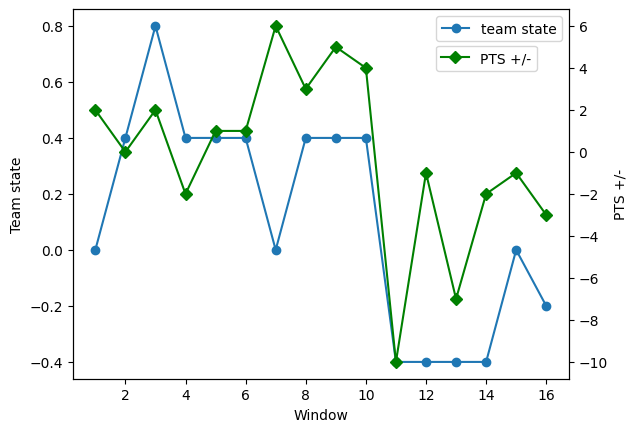

In [16]:
team_state = list(zip(*[Hs_predicted[p] for p in players]))
team_state = np.array([sum(states) for states in team_state])

N = len(team_state)
fig, ax1 = plt.subplots()

ax1.plot(range(1, N+1), team_state / 5 - 1, marker='o', linestyle='-', label = 'team state')
ax1.set_xlabel('Window')
ax1.set_ylabel('Team state')
ax1.legend(loc='upper right')

ax2 = ax1.twinx()
ax2.plot(range(1, N+1), score_diff, marker='D', linestyle='-', color='green', label='PTS +/-')
ax2.set_ylabel('PTS +/-')
ax2.legend()
ax2.legend_.set_bbox_to_anchor((0.95, 0.92))


plt.savefig(f'./team-collapse-games/DEN@LAC.pdf', format='pdf', bbox_inches='tight')
plt.show()